# **Restricted Boltzmann Machine(RBM)**

## Load the MINIST dataset :

In [1]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

BATCHSIZE = 16
VISIBLE_UNITS = 28*28
HIDDEN_UNITS = 100
CD_K = 1
EPOCHS = 10

# load datasets
tr_dataset = datasets.MNIST('data/mnist', train=True, transform=transforms.ToTensor(), download=True)
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=BATCHSIZE)

ts_dataset = datasets.MNIST('data/mnist', train=False, transform=transforms.ToTensor(), download=True)
ts_loader = torch.utils.data.DataLoader(ts_dataset, batch_size=BATCHSIZE)

## Define RBM model

In [2]:
class RBM():
  def __init__(self, n_visible=VISIBLE_UNITS, n_hidden=HIDDEN_UNITS, k=CD_K, lr=1e-3, momentum_rate=0.5, w_decay=1e-4):
    self.n_visible = n_visible
    self.n_hidden = n_hidden
    self.k = k
    self.lr = lr
    self.momentum_rate = momentum_rate
    self.w_decay = w_decay
  
    self.w = torch.randn(n_visible, n_hidden) * 0.1
    #self.w = torch.normal(0, 0.01, size = (n_visible, n_hidden))
    self.visible_b = torch.ones(n_visible) * 0.5
    self.hidden_b = torch.zeros(n_hidden)

    self.w_momentum = torch.zeros(n_visible, n_hidden)
    self.visible_b_momentum = torch.zeros(n_visible)
    self.hidden_b_momentum = torch.zeros(n_hidden)
    self.linear = torch.nn.Linear(784, 10)

  def _sample(self, p, size):
    return (p >= torch.rand(size)).float()

  def v2h(self, visible_p):
    hidden_activations = torch.matmul(visible_p, self.w) + self.hidden_b
    hidden_p = 1 / (1 + torch.exp(-hidden_activations))
    return hidden_p, self._sample(hidden_p, self.n_hidden)

  def h2v(self, hidden):
    visible_activations = torch.matmul(hidden, self.w.t()) + self.visible_b
    visible_p = 1 / (1 + torch.exp(-visible_activations))
    return visible_p, self._sample(visible_p, self.n_visible)

  def cd(self, input):
    # wake part
    pos_hidden_p, pos_hidden = self.v2h(input)
    wake = torch.matmul(input.t(), pos_hidden_p)

    # dream part
    neg_hidden = pos_hidden
    for step in range(self.k):
      recon_visible_p, _ = self.h2v(neg_hidden)
      neg_hidden_p, neg_hidden = self.v2h(recon_visible_p)
    
    dream = torch.matmul(recon_visible_p.t(), neg_hidden_p)
    Delta_w = wake - dream

    #update parameters
    self.w_momentum = self.momentum_rate*(self.w_momentum) + Delta_w
    self.visible_b_momentum = self.momentum_rate*(self.visible_b_momentum) + torch.sum(input - recon_visible_p, dim=0)
    self.hidden_b_momentum = self.momentum_rate*(self.hidden_b_momentum) + torch.sum(pos_hidden_p - neg_hidden_p, dim=0)


    batch_size = input.size(0)
    self.w += self.w_momentum * self.lr / batch_size
    self.visible_b += self.visible_b_momentum * self.lr / batch_size
    self.hidden_b += self.hidden_b_momentum * self.lr / batch_size

    self.w -= self.w * self.w_decay
    #reconstruciton error
    err = torch.sum((input - recon_visible_p)**2)

    return err, input, recon_visible_p, self._sample(recon_visible_p, self.n_visible)

  def train(self, n_epochs, tr_loader):
    # training RBM
    for epoch in range(n_epochs):
      epoch_err = 0.0

      for batch, _ in tr_loader:
        batch = batch.view(len(batch), self.n_visible)
        batch_err, data, recon_data_p, recon_data = self.cd(batch)
        epoch_err += batch_err

      print("Epoch Error (epoch=%d): %.4f" % (epoch+1, epoch_err))


## Train RBM model

In [3]:
rbm = RBM(VISIBLE_UNITS, HIDDEN_UNITS, CD_K)
rbm.train(EPOCHS, tr_loader)

Epoch Error (epoch=1): 3018390.7500
Epoch Error (epoch=2): 1843625.6250
Epoch Error (epoch=3): 1699265.3750
Epoch Error (epoch=4): 1630401.0000
Epoch Error (epoch=5): 1586544.1250
Epoch Error (epoch=6): 1555719.6250
Epoch Error (epoch=7): 1531768.7500
Epoch Error (epoch=8): 1513418.7500
Epoch Error (epoch=9): 1497737.5000
Epoch Error (epoch=10): 1485750.2500


## Define a classification model by placing a softmax layer after the RBM

In [4]:
class myNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(myNet, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = rbm.v2h(x)
        outputs = self.linear(x)

        return F.log_softmax(outputs, dim=1)

In [5]:
myModel = myNet(HIDDEN_UNITS, 10)

### Train the classifier :

In [6]:
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(myModel.parameters(), lr=1e-3)

In [7]:
from torch.autograd import Variable

for epoch in range(10):
  for i, (batch, labels) in enumerate(tr_loader):
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    labels = Variable(labels)

    optimizer.zero_grad()
    outputs = myModel(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # calculate Accuracy
  correct = 0
  total = 0
  y_true = []
  y_pred = []
  for batch, labels in ts_loader:
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    outputs = myModel(batch)
    _, prediction = torch.max(outputs.data, 1)
    y_true.extend(labels)
    y_pred.extend(prediction)
    total += labels.size(0)
    # for gpu, bring the predicted and labels back to cpu fro python operations to work
    correct+= (prediction == labels).sum()
    accuracy = 100 * correct/total
  print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch+1, loss.item(), accuracy))

Epoch: 1. Loss: 0.1404740959405899. Accuracy: 88.30000305175781.
Epoch: 2. Loss: 0.09452859312295914. Accuracy: 89.5.
Epoch: 3. Loss: 0.07875517755746841. Accuracy: 90.16000366210938.
Epoch: 4. Loss: 0.07018809765577316. Accuracy: 90.62999725341797.
Epoch: 5. Loss: 0.06463678926229477. Accuracy: 90.94000244140625.
Epoch: 6. Loss: 0.060719192028045654. Accuracy: 91.13999938964844.
Epoch: 7. Loss: 0.05780782550573349. Accuracy: 91.44000244140625.
Epoch: 8. Loss: 0.0555628277361393. Accuracy: 91.61000061035156.
Epoch: 9. Loss: 0.05378067120909691. Accuracy: 91.70999908447266.
Epoch: 10. Loss: 0.052331894636154175. Accuracy: 91.75.


### Build the confusion matrix :

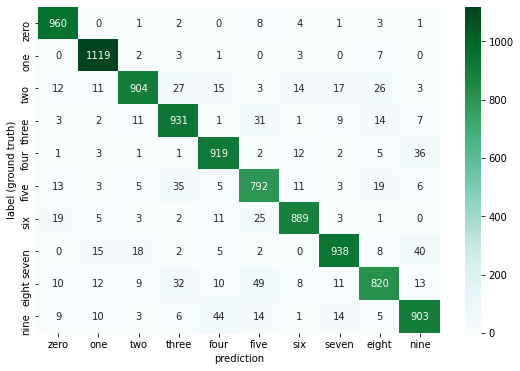

In [8]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

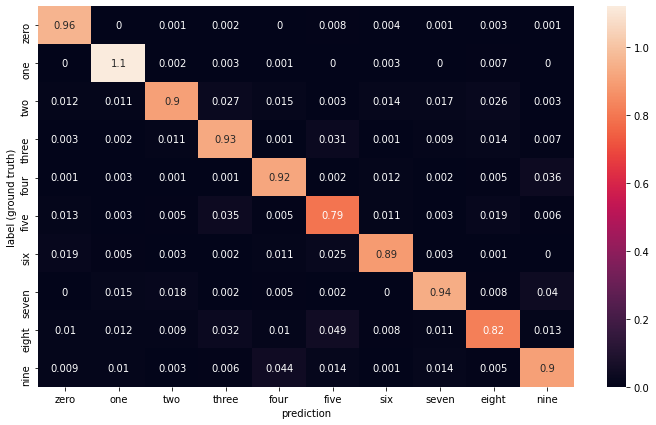

In [9]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

## Define a classification model taking the RBM hidden states as embbedings.

In [10]:
class NewNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NewNet, self).__init__()
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(rbm.w, 0, 1))
        self.fl1.bias.data.copy_(rbm.hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)

        return F.log_softmax(x, dim=1)

In [11]:
Newmodel = NewNet(VISIBLE_UNITS, 10)

In [12]:
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(Newmodel.parameters(), lr=1e-3)

### Train the classifier :

In [13]:
from torch.autograd import Variable

for epoch in range(10):
  for i, (batch, labels) in enumerate(tr_loader):
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    labels = Variable(labels)

    optimizer.zero_grad()
    outputs = Newmodel(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # calculate Accuracy
  correct = 0
  total = 0
  y_true = []
  y_pred = []
  for batch, labels in ts_loader:
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    outputs = Newmodel(batch)
    _, prediction = torch.max(outputs.data, 1)
    y_true.extend(labels)
    y_pred.extend(prediction)
    total += labels.size(0)
    # for gpu, bring the predicted and labels back to cpu fro python operations to work
    correct += (prediction == labels).sum()
    accuracy = 100 * correct/total
  print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch+1, loss.item(), accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1. Loss: 0.019737306982278824. Accuracy: 94.47000122070312.
Epoch: 2. Loss: 0.009464196860790253. Accuracy: 95.9800033569336.
Epoch: 3. Loss: 0.005821946542710066. Accuracy: 96.52999877929688.
Epoch: 4. Loss: 0.0038087605498731136. Accuracy: 96.76000213623047.
Epoch: 5. Loss: 0.0027400334365665913. Accuracy: 96.94999694824219.
Epoch: 6. Loss: 0.0020495476201176643. Accuracy: 97.06999969482422.
Epoch: 7. Loss: 0.0015458236448466778. Accuracy: 97.25.
Epoch: 8. Loss: 0.0011964143486693501. Accuracy: 97.2699966430664.
Epoch: 9. Loss: 0.0009584304061718285. Accuracy: 97.31999969482422.
Epoch: 10. Loss: 0.0007582732359878719. Accuracy: 97.3499984741211.


### Check the pretrained RBM layer weights to make sure it is updated :

In [14]:
Newmodel.fl1.weight.data == torch.transpose(rbm.w, 0, 1)

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [15]:
(Newmodel.fl1.weight.data == torch.transpose(rbm.w, 0, 1)).all()

tensor(False)

### Build the confusion matrix :

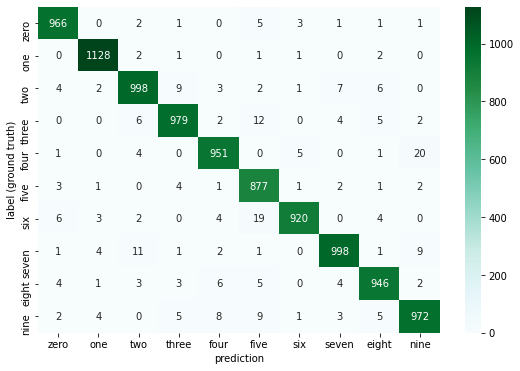

In [16]:
from sklearn.metrics import confusion_matrix
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_true, y_pred)
class_names = ['zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

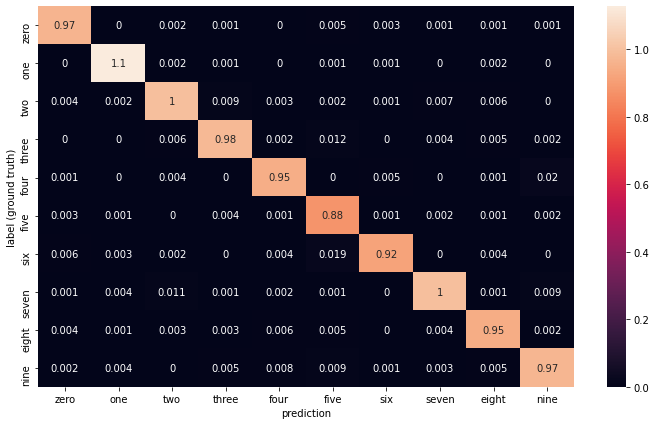

In [17]:
# constant for classes
classes = ('zero', 'one', 'two', 'three', 'four',
        'five', 'six', 'seven', 'eight', 'nine')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True)
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig('output.png')

# **Deep Belief network(DBN)** :

## Transform data:

In [19]:
transform = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
train_data = torch.stack([transform(data) for data in tr_dataset.train_data])

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


## Train DBN

In [18]:
class DBN(nn.Module):
  def __init__(self, n_visible=28*28, n_hiddens=[HIDDEN_UNITS, HIDDEN_UNITS], k=1):
    super(DBN, self).__init__()
    
    self.n_layers = len(n_hiddens)
    self.rbm_layers = []
  
    # creating different RBM layers
    for i in range(self.n_layers):
      n_input = 0;
      if i == 0:
        n_input = n_visible
      else:
        n_input = n_hiddens[i-1]
      rbm = RBM(n_input, n_hiddens[i], k)
      self.rbm_layers.append(rbm)

  def forward(self, input):
    '''
    running the forward pass
    '''
    visible = input 
    for i in range(len(self.rbm_layers)):
      hidden_p, hidden = self.rbm_layers[i].v2h(visible)
      visible = hidden_p
    return hidden_p, hidden

  def reconstruct(self, input):
    '''
    go till the final layer and then reconstruct
    '''
    visible_p = input
    # hidden_p = 0
    for i in range(len(self.rbm_layers)):
      hidden_p, h = self.rbm_layers[i].v2h(visible_p)
      visible_p = hidden_p
    
    hidden = h
    for i in range(len(self.rbm_layers)-1,-1,-1):
      recon_visible_p, recon_visible = self.rbm_layers[i].h2v(hidden)
      hidden = recon_visible
    return recon_visible_p, recon_visible

  def train(self,  train_data, train_labels, n_epochs=10, batch_size=16):
    tmp = train_data
    for i in range(len(self.rbm_layers)):
      print("-"*20)
      print("Training rbm layer number {}".format(i+1))

      tensor_data = tmp.type(torch.FloatTensor)
      tensor_label = train_labels.type(torch.FloatTensor)
      dataset = torch.utils.data.TensorDataset(tensor_data, tensor_label)
      data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

      self.rbm_layers[i].train(n_epochs, data_loader)
      visible = tmp.view((tmp.shape[0], -1)).type(torch.FloatTensor)
      _, hidden = self.rbm_layers[i].v2h(visible)
      tmp = hidden

    return

In [20]:
dbn = DBN()
dbn.train(train_data.squeeze(), tr_dataset.train_labels, n_epochs=10)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


--------------------
Training rbm layer number 1
Epoch Error (epoch=1): 3023150.0000
Epoch Error (epoch=2): 1840595.1250
Epoch Error (epoch=3): 1700529.3750
Epoch Error (epoch=4): 1629439.0000
Epoch Error (epoch=5): 1584585.1250
Epoch Error (epoch=6): 1552946.1250
Epoch Error (epoch=7): 1530044.1250
Epoch Error (epoch=8): 1512291.3750
Epoch Error (epoch=9): 1497079.6250
Epoch Error (epoch=10): 1484352.1250
--------------------
Training rbm layer number 2
Epoch Error (epoch=1): 913502.0625
Epoch Error (epoch=2): 625738.1875
Epoch Error (epoch=3): 557487.4375
Epoch Error (epoch=4): 526521.0625
Epoch Error (epoch=5): 509480.9062
Epoch Error (epoch=6): 498615.5000
Epoch Error (epoch=7): 491420.8438
Epoch Error (epoch=8): 485006.7188
Epoch Error (epoch=9): 480554.6562
Epoch Error (epoch=10): 477705.9688


## Train a classification model by placing a softmax layer after the DBN

In [21]:
class myNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(myNet, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x, _ = dbn.forward(x)
        outputs = self.linear(x)

        return F.log_softmax(outputs, dim=1)

In [22]:
myModel = myNet(HIDDEN_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(myModel.parameters(), lr=1e-3)

In [23]:
from torch.autograd import Variable

for epoch in range(10):
  for i, (batch, labels) in enumerate(tr_loader):
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    labels = Variable(labels)

    optimizer.zero_grad()
    outputs = myModel(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # calculate Accuracy
  correct = 0
  total = 0
  y_true = []
  y_pred = []
  for batch, labels in ts_loader:
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    outputs = myModel(batch)
    _, prediction = torch.max(outputs.data, 1)
    y_true.extend(labels)
    y_pred.extend(prediction)
    total += labels.size(0)
    # for gpu, bring the predicted and labels back to cpu fro python operations to work
    correct+= (prediction == labels).sum()
    accuracy = 100 * correct/total
  print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch+1, loss.item(), accuracy))

Epoch: 1. Loss: 0.19315294921398163. Accuracy: 84.62000274658203.
Epoch: 2. Loss: 0.13791771233081818. Accuracy: 86.19000244140625.
Epoch: 3. Loss: 0.1193300262093544. Accuracy: 86.9000015258789.
Epoch: 4. Loss: 0.10970841348171234. Accuracy: 87.47000122070312.
Epoch: 5. Loss: 0.10350028425455093. Accuracy: 87.76000213623047.
Epoch: 6. Loss: 0.09894995391368866. Accuracy: 88.04000091552734.
Epoch: 7. Loss: 0.09535904973745346. Accuracy: 88.30999755859375.
Epoch: 8. Loss: 0.09239935874938965. Accuracy: 88.5199966430664.
Epoch: 9. Loss: 0.0898931473493576. Accuracy: 88.70999908447266.
Epoch: 10. Loss: 0.08773285895586014. Accuracy: 88.9000015258789.


## Train a classification model taking the DBN hidden states as embbedings.

In [24]:
class NewNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(NewNet, self).__init__()
        self.fl1 = torch.nn.Linear(input_dim, HIDDEN_UNITS)
        self.fl1.weight.data.copy_(torch.transpose(dbn.rbm_layers[0].w, 0, 1))
        self.fl1.bias.data.copy_(dbn.rbm_layers[0].hidden_b)
        self.fl2 = torch.nn.Linear(HIDDEN_UNITS, HIDDEN_UNITS)
        self.fl2.weight.data.copy_(torch.transpose(dbn.rbm_layers[1].w, 0, 1))
        self.fl2.bias.data.copy_(dbn.rbm_layers[1].hidden_b)
        self.fl3 = torch.nn.Linear(HIDDEN_UNITS, output_dim)

    def forward(self, x):
        x = self.fl1(x)
        x = F.sigmoid(x)
        x = self.fl2(x)
        x = F.sigmoid(x)
        x = self.fl3(x)

        return F.log_softmax(x, dim=1)

Newmodel = NewNet(VISIBLE_UNITS, 10)
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy
optimizer = torch.optim.Adam(Newmodel.parameters(), lr=1e-3)

In [25]:
from torch.autograd import Variable

for epoch in range(10):
  for i, (batch, labels) in enumerate(tr_loader):
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    labels = Variable(labels)

    optimizer.zero_grad()
    outputs = Newmodel(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

  # calculate Accuracy
  correct = 0
  total = 0
  y_true = []
  y_pred = []
  for batch, labels in ts_loader:
    batch = Variable(batch.view(-1, VISIBLE_UNITS))
    outputs = Newmodel(batch)
    _, prediction = torch.max(outputs.data, 1)
    y_true.extend(labels)
    y_pred.extend(prediction)
    total += labels.size(0)
    # for gpu, bring the predicted and labels back to cpu fro python operations to work
    correct += (prediction == labels).sum()
    accuracy = 100 * correct/total
  print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch+1, loss.item(), accuracy))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1. Loss: 0.013213245198130608. Accuracy: 94.80999755859375.
Epoch: 2. Loss: 0.005642289761453867. Accuracy: 96.26000213623047.
Epoch: 3. Loss: 0.0037454834673553705. Accuracy: 96.87999725341797.
Epoch: 4. Loss: 0.0033720547799021006. Accuracy: 97.0999984741211.
Epoch: 5. Loss: 0.0029513570480048656. Accuracy: 97.18000030517578.
Epoch: 6. Loss: 0.001761590363457799. Accuracy: 97.25.
Epoch: 7. Loss: 0.0009513968834653497. Accuracy: 97.3499984741211.
Epoch: 8. Loss: 0.0006710560992360115. Accuracy: 97.22000122070312.
Epoch: 9. Loss: 0.0005949838669039309. Accuracy: 97.0999984741211.
Epoch: 10. Loss: 0.0007171205943450332. Accuracy: 96.88999938964844.


# **Plot the results**

In [26]:
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

In [27]:
examples = enumerate(ts_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [28]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data.view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data.view(-1, VISIBLE_UNITS))

### plot raw last batch:

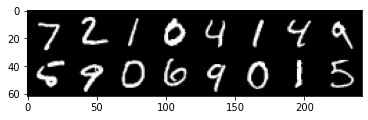

In [29]:
show_adn_save("real",make_grid(example_data.view(example_data.shape[0],1,28,28).data))

### plot reconstructed last batch with propbalitys :

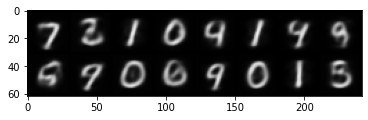

In [30]:
show_adn_save("generate",make_grid(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28).data))

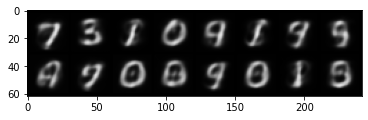

In [31]:
show_adn_save("generate",make_grid(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28).data))

### plot reconstructed last batch with sampled data :

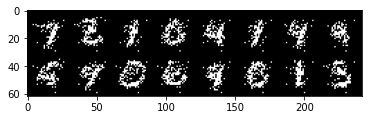

In [32]:
show_adn_save("generate",make_grid(recon_data_RBM.view(recon_data_RBM.shape[0],1,28,28).data))

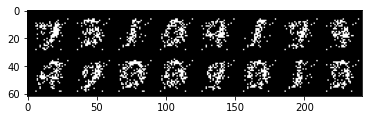

In [33]:
show_adn_save("generate",make_grid(recon_data_DBN.view(recon_data_DBN.shape[0],1,28,28).data))

### plot the reconstruced first batch of test dataset :

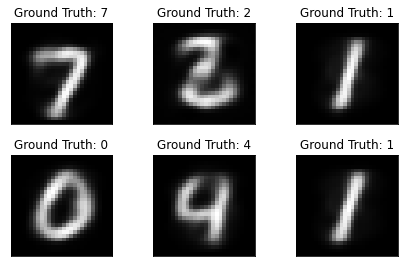

In [34]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

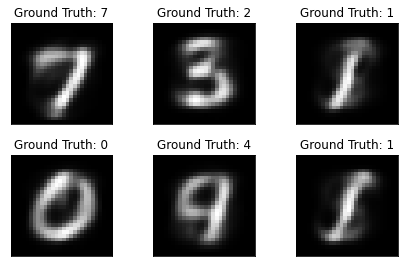

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28)[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## Try to apply affine transformation to the raw img, in result the classifier will make a wrong prediction on the new img: 

Text(0.5, 1.0, 'Ground Truth: 7')

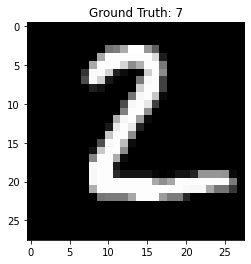

In [36]:
plt.imshow(example_data[1][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[0]))

In [38]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(example_data[1].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(example_data[1].view(-1, VISIBLE_UNITS))

Text(0.5, 1.0, 'Ground Truth: 2')

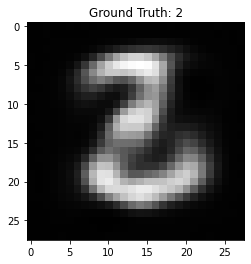

In [39]:
plt.imshow(recon_data_p_RBM.view((28,28)), cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))

Text(0.5, 1.0, 'Ground Truth: 2')

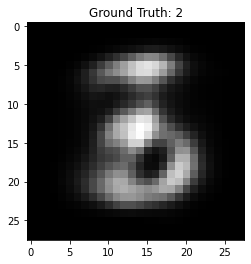

In [40]:
plt.imshow(recon_data_p_DBN.view((28,28)), cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))

### Define a composed transforms :

In [41]:
compose = transforms.Compose([transforms.RandomAffine(10, translate = (0.02,0.09)),transforms.Resize((28,28))])

### Apply affine transforms :

Text(0.5, 1.0, 'Ground Truth: 2')

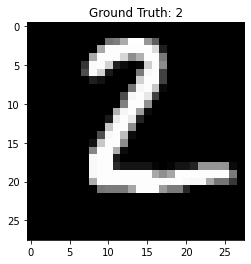

In [42]:
test = example_data[1]
compose(test).shape
plt.imshow(compose(test)[0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {}".format(example_targets[1]))

### Check the prediction :

In [43]:
batch = Variable(compose(test).view(-1, VISIBLE_UNITS))
outputs = Newmodel(batch)
_, prediction = torch.max(outputs.data, 1)
prediction

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([2])

### reconstruct the new img by RBM

In [44]:
recon_data_p_RBM, recon_data_RBM = rbm.h2v(rbm.v2h(compose(test)[0].view(-1, VISIBLE_UNITS))[0])
recon_data_p_DBN, recon_data_DBN = dbn.reconstruct(compose(test)[0].view(-1, VISIBLE_UNITS))

### plot the reconstructed new img

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

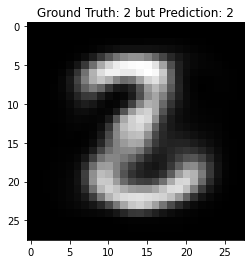

In [45]:
plt.imshow(recon_data_p_RBM.view(recon_data_p_RBM.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))

Text(0.5, 1.0, 'Ground Truth: 2 but Prediction: 2')

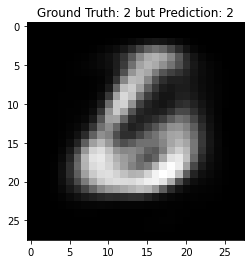

In [46]:
plt.imshow(recon_data_p_DBN.view(recon_data_p_DBN.shape[0],1,28,28)[0][0], cmap='gray', interpolation='none')
plt.title("Ground Truth: {} but Prediction: {}".format(example_targets[1],*(prediction.numpy())))